# Evaluation VPropNN

# Load Data

In [32]:
import tensorflow as tf

### Configuration
create_dataset = False

def in_google_colab():
    """Checks if the code is running in Google Colab

    Returns:
        bool: _description_
    """
    try:
        import google.colab
        return True
    except ImportError:
        return False

if in_google_colab():
    print("Running in Google Colab")
    # Install necessary packages in Google Colab
    !rm -r sample_data/
    !git clone https://github.com/naderinho/anesthesia_anomaly_detection
    !cp -r anesthesia_anomaly_detection/* .
    !rm -r anesthesia_anomaly_detection/
    !pip install vitaldb
    create_dataset = False
else:
    print("Running locally")

### Datasetpath
directory = 'data/'
datasetpath = 'dataset04/'
vitaldbpath = 'vitaldb_tiva/'

### Import the necessary libraries
import numpy as np
import pandas as pd
import vitaldb as vf
import matplotlib.pyplot as plt
import pickle

### Custom functions
import modules as md

Running locally


In [33]:
### Load the datasets
bis = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bis.load('00_bis.npz')

info = md.infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
info.load('01_info.npz')

info_non_norm = md.infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
info_non_norm.load('01_info_norm_none.npz')

bloodpressure = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bloodpressure.load('02_bloodpressure.npz')

etCO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
etCO2.load('02_etCO2.npz')

spO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
spO2.load('02_spO2.npz')

hr = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
hr.load('02_hr.npz')

propofolrate = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
propofolrate.load('03_propofol_rate.npz')

train_index, val_index, test_index = bis.split(np.array(bis.index))

In [34]:
# Load test prediction data
with open('models/VPropNN/infusion_gender_equal/prediction.pkl', 'rb') as f:
    y_pred = pickle.load(f)

from utils.evaluation import phases_report, phases_report_std

# MDPE

In [35]:
timefilter = (bis.test_dataset == 0.0)

groundtruth = np.copy(bis.test_dataset)
groundtruth[timefilter] = np.nan
groundtruth = groundtruth

y_pred[timefilter] = np.nan
y_pred_all = y_pred


mdpe_all = np.nanmedian((groundtruth - y_pred_all) / groundtruth * 100)
mdpe_m = np.nanmedian((groundtruth[m_index_test] - y_pred[m_index_test]) / groundtruth[m_index_test] * 100)
mdpe_f = np.nanmedian((groundtruth[f_index_test] - y_pred[f_index_test]) / groundtruth[f_index_test] * 100)

print(mdpe_all, mdpe_m, mdpe_f)

1.3845181 4.545061 -0.6685978


# Seperate Data

## Seperate the Data in + 60 years and older patients

In [4]:
young_index_train = np.where(info_non_norm.train_dataset[:,1] <  60)
old_index_train   = np.where(info_non_norm.train_dataset[:,1] >= 60)

print(young_index_train[0].shape, old_index_train[0].shape)

young_index_val = np.where(info_non_norm.validation_dataset[:,1] <  60)
old_index_val   = np.where(info_non_norm.validation_dataset[:,1] >= 60)

print(young_index_val[0].shape, old_index_val[0].shape)

young_index_test = np.where(info_non_norm.test_dataset[:,1] <  60)
old_index_test   = np.where(info_non_norm.test_dataset[:,1] >= 60)

print(young_index_test[0].shape, old_index_test[0].shape)

(34,) (39,)
(6,) (7,)
(7,) (9,)


## Seperate the Data in Male and Female patients

In [5]:
m_index_train = np.where(info.train_dataset[:,0] == 0.5)
f_index_train = np.where(info.train_dataset[:,0] == -0.5)

print(m_index_train[0].shape, f_index_train[0].shape)

m_index_val = np.where(info.validation_dataset[:,0] == 0.5)
f_index_val = np.where(info.validation_dataset[:,0] == -0.5)

print(m_index_val[0].shape, f_index_val[0].shape)

m_index_test = np.where(info.test_dataset[:,0] == 0.5)
f_index_test = np.where(info.test_dataset[:,0] == -0.5)

print(m_index_test[0].shape, f_index_test[0].shape)

(37,) (36,)
(8,) (5,)
(6,) (10,)


## Seperate by BMI

In [6]:
bmi = 23

bmi_1_index_train = np.where(info_non_norm.train_dataset[:,4] < bmi)
bmi_2_index_train = np.where(info_non_norm.train_dataset[:,4] >= bmi)

print(bmi_1_index_train[0].shape, bmi_2_index_train[0].shape)

bmi_1_index_validation = np.where(info_non_norm.validation_dataset[:,4] < bmi)
bmi_2_index_validation = np.where(info_non_norm.validation_dataset[:,4] >= bmi)

print(bmi_1_index_validation[0].shape, bmi_2_index_validation[0].shape)

bmi_1_index_test = np.where(info_non_norm.test_dataset[:,4] < bmi)
bmi_2_index_test = np.where(info_non_norm.test_dataset[:,4] >= bmi)

print(bmi_1_index_test[0].shape, bmi_2_index_test[0].shape)

(41,) (32,)
(7,) (6,)
(9,) (7,)


# Gesamtfehler

In [7]:
all_rep = phases_report(y_pred, bis.test_dataset, propofolrate.test_dataset)
all_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,91.70,190.75,7.31,9.53,9.58,13.81
Induction,140.51,825.47,9.57,22.00,11.85,28.73
Maintenance,71.81,90.95,6.51,7.21,8.47,9.54
Recovery,188.96,408.94,10.86,16.34,13.75,20.22


In [8]:
all_rep_std = phases_report_std(all_rep, y_pred, bis.test_dataset, propofolrate.test_dataset)
all_rep_std

All      	min: 	 11 	max: 	 2
Induction 	min: 	 15 	max: 	 6
Maintenance 	min: 	 8 	max: 	 2
Recovery 	min: 	 12 	max: 	 0


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,54.30,113.05,2.57,3.86,2.58,3.56
Induction,68.58,474.70,2.57,8.60,2.67,8.16
Maintenance,54.31,93.50,2.79,4.14,2.84,3.96
Recovery,129.10,171.55,4.44,5.37,4.61,4.22


# Testing Age

## > 60 years

In [9]:
old_rep = phases_report(y_pred[old_index_test], bis.test_dataset[old_index_test], propofolrate.test_dataset[old_index_test])
old_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,98.02,214.80,7.61,10.01,9.90,14.66
Induction,114.38,840.14,8.58,22.70,10.69,28.99
Maintenance,84.30,106.94,7.05,7.48,9.18,10.34
Recovery,179.51,463.72,10.57,17.53,13.40,21.53


In [10]:
old_rep_std = phases_report_std(old_rep,y_pred[old_index_test], bis.test_dataset[old_index_test], propofolrate.test_dataset[old_index_test])
old_rep_std

All      	min: 	 7 	max: 	 2
Induction 	min: 	 3 	max: 	 2
Maintenance 	min: 	 4 	max: 	 2
Recovery 	min: 	 7 	max: 	 0


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,49.44,111.60,2.52,4.08,2.38,3.40
Induction,43.22,431.02,1.83,8.74,1.93,7.42
Maintenance,57.15,94.47,2.93,4.26,2.83,3.99
Recovery,137.60,188.53,4.41,5.43,4.76,4.44


## < 60 years

In [11]:
young_rep = phases_report(y_pred[young_index_test], bis.test_dataset[young_index_test], propofolrate.test_dataset[young_index_test])
young_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,84.97,165.17,6.98,9.03,9.22,12.85
Induction,173.56,806.92,10.83,21.10,13.17,28.41
Maintenance,58.62,74.06,5.95,6.93,7.66,8.61
Recovery,198.25,355.06,11.15,15.16,14.08,18.84


In [12]:
young_rep_std = phases_report_std(young_rep, y_pred[young_index_test], bis.test_dataset[young_index_test], propofolrate.test_dataset[young_index_test])
young_rep_std

All      	min: 	 4 	max: 	 0
Induction 	min: 	 6 	max: 	 3
Maintenance 	min: 	 5 	max: 	 6
Recovery 	min: 	 1 	max: 	 2


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,59.90,110.61,2.63,3.55,2.83,3.59
Induction,80.51,524.42,2.85,8.25,2.94,8.97
Maintenance,50.00,92.19,2.61,3.94,2.83,3.92
Recovery,117.26,132.29,4.47,5.18,4.41,3.61


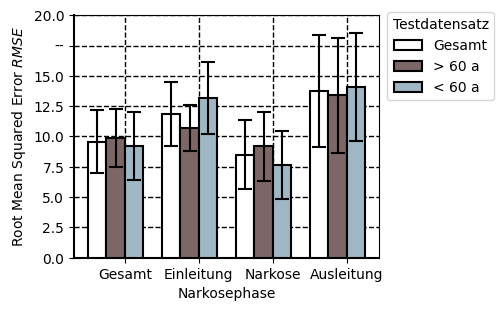

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

### Plot

fig = plt.figure(figsize=(10/2.54, 8/2.54))
label = ['Gesamt','> 60 a', '< 60 a']
x_label = ['Gesamt','Einleitung', 'Narkose', 'Ausleitung']

x = np.arange(len(x_label))  # the label locations
width = 0.25  # the width of the bars
multiplier = -1.5

color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

colors =  [color2, color4, color3]
report = [all_rep, old_rep, young_rep]
report_std = [all_rep_std, old_rep_std, young_rep_std]


for rep, rep_std, color, lab in zip(report, report_std, colors, label):
    offset = width * multiplier
    rects = plt.bar(x + offset, list(rep["Prediction RMSE"]), width, label=lab, color=color, edgecolor='black', linewidth=1.5, zorder=3)
    plt.errorbar(x + offset, list(rep["Prediction RMSE"]), yerr=list(rep_std["Prediction RMSE"]), fmt='none', ecolor='black', elinewidth=1.5, capsize=5, capthick=1.5, zorder=4)
    multiplier += 1

plt.legend(title='Testdatensatz', loc='upper right', ncol=1, bbox_to_anchor=(1.4, 1.04))

plt.ylabel('Root Mean Squared Error $RMSE$')
plt.xlabel('Narkosephase')
plt.grid(True, linestyle='--',color='k', linewidth=1, zorder=0)


# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.set_ylim(bottom=0, top=20.0)

# Einheiten auf y-Achse
yunit = '--'
ticks = list(range(0, 210, 25))
ticks = [tick/10 for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_with_units)

ax.set_xticks(x)
ax.set_xticklabels(x_label)

plt.grid(axis='y', linewidth=1.0)

x = 3.9
#plt.text(x, 0, s='Modell: VProp', fontsize=10, fontweight='bold')

plt.savefig('age_rmse.pdf', bbox_inches='tight', pad_inches=0.2, format='pdf')
plt.show()

# Testing Gender

## Male

In [14]:
male_rep = phases_report(y_pred[m_index_test], bis.test_dataset[m_index_test], propofolrate.test_dataset[m_index_test])
male_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,84.28,158.01,7.10,8.95,9.18,12.57
Induction,145.04,617.29,9.73,17.58,12.04,24.85
Maintenance,67.76,79.13,6.44,7.11,8.23,8.90
Recovery,158.49,390.63,9.84,16.28,12.59,19.76


In [15]:
male_rep_std = phases_report_std(male_rep,y_pred[m_index_test], bis.test_dataset[m_index_test], propofolrate.test_dataset[m_index_test])
male_rep_std

All      	min: 	 3 	max: 	 5
Induction 	min: 	 2 	max: 	 1
Maintenance 	min: 	 4 	max: 	 5
Recovery 	min: 	 3 	max: 	 0


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,39.62,49.85,1.90,2.03,1.95,1.96
Induction,92.55,468.14,3.14,7.91,3.38,7.63
Maintenance,44.37,55.86,2.26,2.66,2.47,2.73
Recovery,83.11,122.08,3.18,3.13,3.19,3.42


## Female

In [16]:
fem_rep = phases_report(y_pred[f_index_test], bis.test_dataset[f_index_test], propofolrate.test_dataset[f_index_test])
fem_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,96.85,213.49,7.45,9.93,9.84,14.61
Induction,137.18,978.99,9.46,25.25,11.71,31.29
Maintenance,74.68,99.34,6.57,7.28,8.64,9.97
Recovery,206.02,419.18,11.43,16.37,14.35,20.47


In [17]:
fem_rep_std = phases_report_std(fem_rep,y_pred[f_index_test], bis.test_dataset[f_index_test], propofolrate.test_dataset[f_index_test])
fem_rep_std

All      	min: 	 8 	max: 	 2
Induction 	min: 	 9 	max: 	 2
Maintenance 	min: 	 5 	max: 	 2
Recovery 	min: 	 4 	max: 	 0


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,60.07,126.29,2.85,4.43,2.85,3.89
Induction,47.93,434.07,2.13,7.76,2.12,7.63
Maintenance,58.01,104.63,3.02,4.69,2.97,4.32
Recovery,148.38,187.10,5.01,6.25,5.27,4.44


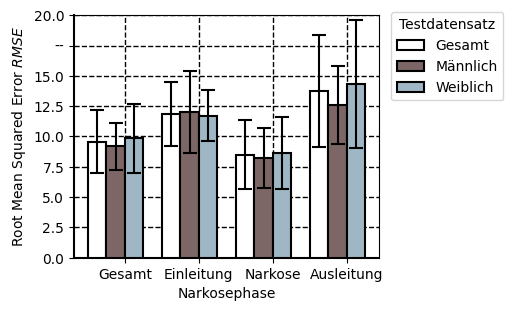

In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

### Plot

fig = plt.figure(figsize=(10/2.54, 8/2.54))
label = ['Gesamt','Männlich', 'Weiblich']
x_label = ['Gesamt','Einleitung', 'Narkose', 'Ausleitung']

x = np.arange(len(x_label))  # the label locations
width = 0.25  # the width of the bars
multiplier = -1.5

color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

colors =  [color2, color4, color3]
report = [all_rep, male_rep, fem_rep]
report_std = [all_rep_std, male_rep_std, fem_rep_std]

for rep, rep_std, color, lab in zip(report, report_std, colors, label):
    offset = width * multiplier
    rects = plt.bar(x + offset, list(rep["Prediction RMSE"]), width, label=lab, color=color, edgecolor='black', linewidth=1.5, zorder=3)
    plt.errorbar(x + offset, list(rep["Prediction RMSE"]), yerr=list(rep_std["Prediction RMSE"]), fmt='none', ecolor='black', elinewidth=1.5, capsize=5, capthick=1.5, zorder=4)
    multiplier += 1

plt.legend(title='Testdatensatz', loc='upper right', ncol=1, bbox_to_anchor=(1.43, 1.04))

plt.ylabel('Root Mean Squared Error $RMSE$')
plt.xlabel('Narkosephase')
plt.grid(True, linestyle='--',color='k', linewidth=1, zorder=0)


# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.set_ylim(bottom=0, top=20)

# Einheiten auf y-Achse
yunit = '--'
ticks = list(range(0, 210, 25))
ticks = [tick/10 for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_with_units)

ax.set_xticks(x)
ax.set_xticklabels(x_label)

plt.grid(axis='y', linewidth=1.0)

x = 3.9
#plt.text(x, 0, s='Modell: VProp', fontsize=10, fontweight='bold')

plt.savefig('gender_rmse.pdf', bbox_inches='tight', pad_inches=0.2, format='pdf')
plt.show()

# BIS Verteilung M/W

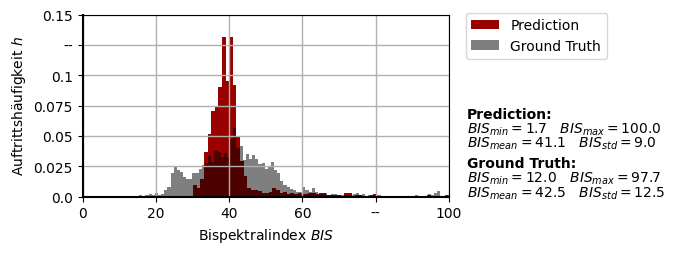

In [19]:
from utils.plotting import full_histogramm_plot

plot = full_histogramm_plot(groundtruth = bis.test_dataset[m_index_test], prediction = y_pred[m_index_test], filename='histogramm_m.pdf')
plot.show()

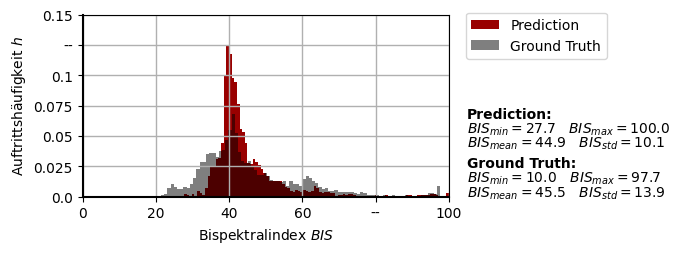

In [20]:
plot = full_histogramm_plot(groundtruth = bis.test_dataset[f_index_test], prediction = y_pred[f_index_test], filename='histogramm_f.pdf')
plot.show()

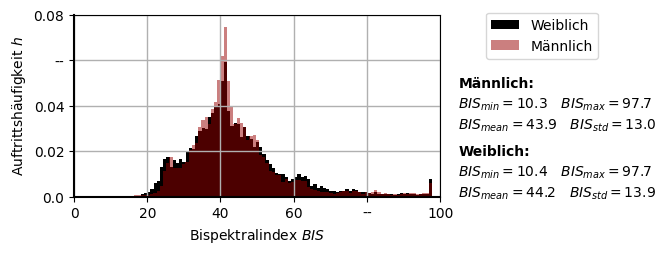

In [21]:
timefilter_m = (bis.train_dataset[m_index_train] == 0.0).flatten()
timefilter_f = (bis.train_dataset[f_index_train] == 0.0).flatten()

y_pred_m = bis.train_dataset[m_index_train].flatten()
y_pred_m[timefilter_m] = np.nan

y_pred_f = bis.train_dataset[f_index_train].flatten()
y_pred_f[timefilter_f] = np.nan

# Colors
color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

plt.figure(figsize=(12/2.54, 6/2.54))
plt.rcParams['font.size'] = 10

plt.hist(y_pred_f, bins=100, density=True, color=color1, label='Weiblich')
plt.hist(y_pred_m, bins=100, density=True, color=color5, label='Männlich', alpha=0.5)


plt.xlabel('Bispektralindex $BIS$')
plt.ylabel('Auftrittshäufigkeit $h$')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1.05))


# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.set_ylim(bottom=0)
ax.set_xlim(left=0, right=100)

# Einheiten auf x-Achse
xunit = '--'
ticks = ax.get_xticks()
ticks = [int(tick) for tick in ticks]
ticks_with_units = [xunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks_with_units)

# Einheiten auf y-Achse
yunit = '--'
ticks = ax.get_yticks()
ticks = [float('{:.3f}'.format(tick)) for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_with_units)

plt.grid(True, linewidth=1.0)

pred_max = np.nanmax(y_pred_m)
pred_min = np.nanmin(y_pred_m)
pred_mean = np.nanmean(y_pred_m)
pred_std = np.nanstd(y_pred_m)

ground_max = np.nanmax(y_pred_f)
ground_min = np.nanmin(y_pred_f)
ground_mean = np.nanmean(y_pred_f)
ground_std = np.nanstd(y_pred_f)

t = 105

plt.text(t, 0.048, s='Männlich:', fontweight='bold')
plt.text(t, 0.039, s='$BIS_{min}  = $' + '${:.1f}$'.format(pred_min)  + '$\quad BIS_{max} = $' + '${:.1f}$'.format(pred_max))
plt.text(t, 0.030, s='$BIS_{mean} = $' + '${:.1f}$'.format(pred_mean) + '$\quad BIS_{std} = $' + '${:.1f}$'.format(pred_std))

plt.text(t, 0.018, s='Weiblich:', fontweight='bold')
plt.text(t, 0.009, s='$BIS_{min}  = $' + '${:.1f}$'.format(ground_min)  + '$\quad BIS_{max} = $' + '${:.1f}$'.format(ground_max))
plt.text(t, 0.000, s='$BIS_{mean} = $' + '${:.1f}$'.format(ground_mean) + '$\quad BIS_{std} = $' + '${:.1f}$'.format(ground_std))

plt.savefig('test.pdf', bbox_inches='tight', pad_inches=0.2, format='pdf')

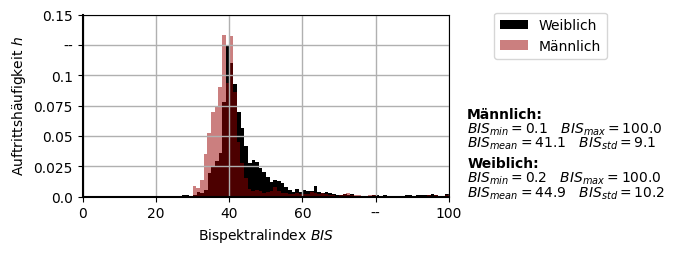

In [22]:
timefilter_m = (y_pred[m_index_test] == 0.0).flatten()
timefilter_f = (y_pred[f_index_test] == 0.0).flatten()

y_pred_m = y_pred[m_index_test].flatten()
y_pred_m[timefilter_m] = np.nan

y_pred_f = y_pred[f_index_test].flatten()
y_pred_f[timefilter_f] = np.nan

# Colors
color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

plt.figure(figsize=(12/2.54, 6/2.54))
plt.rcParams['font.size'] = 10

plt.hist(y_pred_f, bins=100, density=True, color=color1, label='Weiblich')
plt.hist(y_pred_m, bins=100, density=True, color=color5, label='Männlich', alpha=0.5)


plt.xlabel('Bispektralindex $BIS$')
plt.ylabel('Auftrittshäufigkeit $h$')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1.05))


# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.set_ylim(bottom=0)
ax.set_xlim(left=0, right=100)

# Einheiten auf x-Achse
xunit = '--'
ticks = ax.get_xticks()
ticks = [int(tick) for tick in ticks]
ticks_with_units = [xunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks_with_units)

# Einheiten auf y-Achse
yunit = '--'
ticks = ax.get_yticks()
ticks = [float('{:.3f}'.format(tick)) for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_with_units)

plt.grid(True, linewidth=1.0)

pred_max = np.nanmax(y_pred_m)
pred_min = np.nanmin(y_pred_m)
pred_mean = np.nanmean(y_pred_m)
pred_std = np.nanstd(y_pred_m)

ground_max = np.nanmax(y_pred_f)
ground_min = np.nanmin(y_pred_f)
ground_mean = np.nanmean(y_pred_f)
ground_std = np.nanstd(y_pred_f)

t = 105

plt.text(t, 0.065, s='Männlich:', fontweight='bold')
plt.text(t, 0.053, s='$BIS_{min}  = $' + '${:.1f}$'.format(pred_min)  + '$\quad BIS_{max} = $' + '${:.1f}$'.format(pred_max))
plt.text(t, 0.041, s='$BIS_{mean} = $' + '${:.1f}$'.format(pred_mean) + '$\quad BIS_{std} = $' + '${:.1f}$'.format(pred_std))

plt.text(t, 0.024, s='Weiblich:', fontweight='bold')
plt.text(t, 0.012, s='$BIS_{min}  = $' + '${:.1f}$'.format(ground_min)  + '$\quad BIS_{max} = $' + '${:.1f}$'.format(ground_max))
plt.text(t, 0.000, s='$BIS_{mean} = $' + '${:.1f}$'.format(ground_mean) + '$\quad BIS_{std} = $' + '${:.1f}$'.format(ground_std))

plt.savefig('test.pdf', bbox_inches='tight', pad_inches=0.2, format='pdf')

# Propofolinfusionen Vergleich

In [23]:
proprate_m = propofolrate.train_dataset[m_index_train][:,:,0] * 20          # in mg/h 
weight_m = info_non_norm.train_dataset[m_index_train][:,3][np.newaxis].T    # in kg
rate_norm_m = proprate_m / weight_m                                         # in mg/h

proprate_f = propofolrate.train_dataset[f_index_train][:,:,0] * 20          # in mg/h
weight_f = info_non_norm.train_dataset[f_index_train][:,3][np.newaxis].T    # in kg
rate_norm_f = proprate_f / weight_f                                         # in mg/h

timefilter_m = np.logical_or(rate_norm_m < 1, rate_norm_m > 15)             # Nach LAR16a
timefilter_f = np.logical_or(rate_norm_f < 1, rate_norm_f > 15)

rate_norm_m[timefilter_m] = np.nan
rate_norm_f[timefilter_f] = np.nan

print("Mean:\t M: {:.3f}\tF: {:.3f}".format(np.nanmean(rate_norm_m), np.nanmean(rate_norm_f)))
print("Std:\t M: {:.3f}\tF: {:.3f}".format(np.nanstd(rate_norm_m), np.nanstd(rate_norm_f)))

Mean:	 M: 6.421	F: 6.553
Std:	 M: 2.225	F: 2.092


# Testing BMI

## BMI >= 23

In [24]:
bmi1_rep = phases_report(y_pred[bmi_1_index_test], bis.test_dataset[bmi_1_index_test], propofolrate.test_dataset[bmi_1_index_test])
bmi1_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,104.68,190.77,7.81,9.58,10.23,13.81
Induction,174.04,"1,015.83",10.83,25.92,13.19,31.87
Maintenance,78.68,94.23,6.80,7.29,8.87,9.71
Recovery,261.25,402.74,13.59,16.75,16.16,20.07


In [25]:
bmi1_rep_std = phases_report_std(bmi1_rep,y_pred[bmi_1_index_test], bis.test_dataset[bmi_1_index_test], propofolrate.test_dataset[bmi_1_index_test])
bmi1_rep_std

All      	min: 	 6 	max: 	 1
Induction 	min: 	 6 	max: 	 4
Maintenance 	min: 	 7 	max: 	 1
Recovery 	min: 	 3 	max: 	 0


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,60.60,135.58,2.84,4.55,2.80,4.17
Induction,73.81,473.11,2.63,8.38,2.73,7.79
Maintenance,60.40,94.90,2.98,4.01,3.02,3.91
Recovery,126.72,157.45,3.96,4.67,4.04,3.80


## BMI < 23

In [26]:
bmi2_rep = phases_report(y_pred[bmi_2_index_test], bis.test_dataset[bmi_2_index_test], propofolrate.test_dataset[bmi_2_index_test])
bmi2_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,69.33,190.72,6.44,9.46,8.33,13.81
Induction,105.03,623.98,8.24,17.84,10.25,24.98
Maintenance,58.70,84.68,5.97,7.05,7.66,9.20
Recovery,95.01,416.99,7.32,15.80,9.75,20.42


In [27]:
bmi2_rep_std = phases_report_std(bmi2_rep,y_pred[bmi_2_index_test], bis.test_dataset[bmi_2_index_test], propofolrate.test_dataset[bmi_2_index_test])
bmi2_rep_std

All      	min: 	 5 	max: 	 0
Induction 	min: 	 6 	max: 	 4
Maintenance 	min: 	 3 	max: 	 6
Recovery 	min: 	 5 	max: 	 0


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,23.92,73.27,1.47,2.59,1.45,2.57
Induction,30.02,387.41,1.44,6.57,1.44,7.12
Maintenance,37.30,89.60,2.28,4.20,2.25,3.90
Recovery,74.65,187.09,2.82,5.90,3.25,4.66


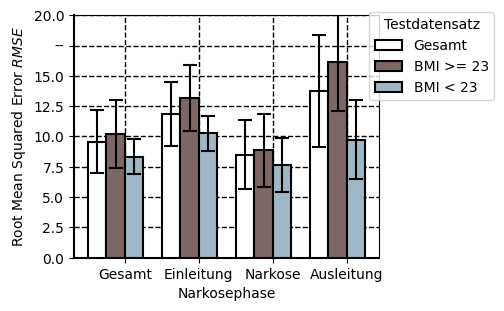

In [28]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

### Plot

fig = plt.figure(figsize=(10/2.54, 8/2.54))
label = ['Gesamt','BMI >= 23', 'BMI < 23']
x_label = ['Gesamt','Einleitung', 'Narkose', 'Ausleitung']

x = np.arange(len(x_label))  # the label locations
width = 0.25  # the width of the bars
multiplier = -1.5

color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

colors =  [color2, color4, color3]
report = [all_rep, bmi1_rep, bmi2_rep]
report_std = [all_rep_std, bmi1_rep_std, bmi2_rep_std]


for rep, rep_std, color, lab in zip(report, report_std, colors, label):
    offset = width * multiplier
    rects = plt.bar(x + offset, list(rep["Prediction RMSE"]), width, label=lab, color=color, edgecolor='black', linewidth=1.5, zorder=3)
    plt.errorbar(x + offset, list(rep["Prediction RMSE"]), yerr=list(rep_std["Prediction RMSE"]), fmt='none', ecolor='black', elinewidth=1.5, capsize=5, capthick=1.5, zorder=4)
    multiplier += 1

plt.legend(title='Testdatensatz', loc='upper right', ncol=1, bbox_to_anchor=(1.4, 1.04))

plt.ylabel('Root Mean Squared Error $RMSE$')
plt.xlabel('Narkosephase')
plt.grid(True, linestyle='--',color='k', linewidth=1, zorder=0)


# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.set_ylim(bottom=0, top=20.0)

# Einheiten auf y-Achse
yunit = '--'
ticks = list(range(0, 210, 25))
ticks = [tick/10 for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_with_units)

ax.set_xticks(x)
ax.set_xticklabels(x_label)

plt.grid(axis='y', linewidth=1.0)

x = 3.9
#plt.text(x, 0, s='Modell: VProp', fontsize=10, fontweight='bold')

plt.savefig('bmi_rmse.pdf', bbox_inches='tight', pad_inches=0.2, format='pdf')
plt.show()

# Einzelfehler

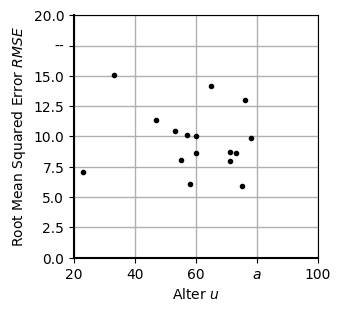

In [29]:
rmse = []
for i, data in enumerate(bis.test_dataset):
    rmse.append(phases_report(y_pred[i:i+1], bis.test_dataset[i:i+1], propofolrate.test_dataset[i:i+1])['Prediction RMSE']['All'])

rmse = np.array(rmse)

columns = ['sex','age','height','weight','bmi']

plt.figure(figsize=(8/2.54, 8/2.54))
plt.rcParams['font.size'] = 10

# Colors
color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

plt.plot(info_non_norm.test_dataset[:,1],rmse, '.', color=color1, label='RMSE')

plt.xlabel('Alter $u$')
plt.ylabel('Root Mean Squared Error $RMSE$')

# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.set_ylim(bottom=0, top=20)
ax.set_xlim(left=20, right=100)

# Einheiten auf x-Achse
xunit = '$a$'
ticks = ax.get_xticks()
ticks = [int(tick) for tick in ticks]
ticks_with_units = [xunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks_with_units)

# Einheiten auf y-Achse
yunit = '--'
ticks = ax.get_yticks()
ticks = [float(tick) for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_with_units)

plt.grid(True, linewidth=1.0)

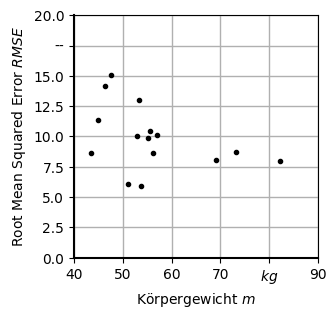

In [30]:
rmse = []
for i, data in enumerate(bis.test_dataset):
    rmse.append(phases_report(y_pred[i:i+1], bis.test_dataset[i:i+1], propofolrate.test_dataset[i:i+1])['Prediction RMSE']['All'])

rmse = np.array(rmse)

columns = ['sex','age','height','weight','bmi']

plt.figure(figsize=(8/2.54, 8/2.54))
plt.rcParams['font.size'] = 10

# Colors
color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

plt.plot(info_non_norm.test_dataset[:,3],rmse, '.', color=color1, label='RMSE')

plt.xlabel('Körpergewicht $m$')
plt.ylabel('Root Mean Squared Error $RMSE$')

# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.set_ylim(bottom=0, top=20)
ax.set_xlim(left=40, right=90)

# Einheiten auf x-Achse
xunit = '$kg$'
ticks = ax.get_xticks()
ticks = [int(tick) for tick in ticks]
ticks_with_units = [xunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks_with_units)

# Einheiten auf y-Achse
yunit = '--'
ticks = ax.get_yticks()
ticks = [float(tick) for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_with_units)

plt.grid(True, linewidth=1.0)

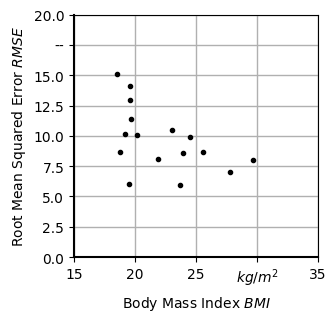

In [31]:
rmse = []
for i, data in enumerate(bis.test_dataset):
    rmse.append(phases_report(y_pred[i:i+1], bis.test_dataset[i:i+1], propofolrate.test_dataset[i:i+1])['Prediction RMSE']['All'])

rmse = np.array(rmse)

columns = ['sex','age','height','weight','bmi']

plt.figure(figsize=(8/2.54, 8/2.54))
plt.rcParams['font.size'] = 10

# Colors
color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

plt.plot(info_non_norm.test_dataset[:,4],rmse, '.', color=color1, label='RMSE')

plt.xlabel('Body Mass Index $BMI$')
plt.ylabel('Root Mean Squared Error $RMSE$')

# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.set_ylim(bottom=0, top=20)
ax.set_xlim(left=15, right=35)

# Einheiten auf x-Achse
xunit = '$kg/m^2$'
ticks = ax.get_xticks()
ticks = [int(tick) for tick in ticks]
ticks_with_units = [xunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks_with_units)

# Einheiten auf y-Achse
yunit = '--'
ticks = ax.get_yticks()
ticks = [float(tick) for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_with_units)

plt.grid(True, linewidth=1.0)